Версии:

- pandas==1.4.2
- numpy==1.20.3
- matplotlib==3.4.3
- seaborn==0.11.2
- nltk==3.6.5
- scipy==1.7.1
- lightgbm==3.3.2
- tqdm==4.62.3
- scikit-learn==1.0.2
- catboost==0.26.1

In [1]:
import re
import calendar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk.corpus
import scipy.sparse
import lightgbm as lgb
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer
from catboost import CatBoostRegressor
from catboost.utils import eval_metric

import warnings
warnings.simplefilter('ignore')

# EDA

## Загрузка данных

In [2]:
df = pd.read_csv(r'.\junior\regression\data_regression_for_task.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128355 entries, 0 to 128354
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   YEAR           128355 non-null  int64  
 1   MONTH          128355 non-null  int64  
 2   CONTRAGENT     128331 non-null  object 
 3   ARTICLE_CODE   128355 non-null  object 
 4   ARTICLE_NAME   128355 non-null  object 
 5   ARTICLE_GROUP  128354 non-null  object 
 6   SALES          128355 non-null  float64
 7   STORE_SALES    128355 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 7.8+ MB


Проверка на дубликаты

In [4]:
df.duplicated().sum()

0

Просмотр данных

Проверка на пропуски

In [5]:
df.isnull().sum()

YEAR              0
MONTH             0
CONTRAGENT       24
ARTICLE_CODE      0
ARTICLE_NAME      0
ARTICLE_GROUP     1
SALES             0
STORE_SALES       0
dtype: int64

В данных присутствуют пропуски, но в незначительном количестве, поэтому их можно будет удалить.

ARTICLE_CODE и ARTICLE_NAME обозначают одно и то же, но с именами нам легче работать. Также важно отметить, что признаки будут иметь высокую ковариацию, что плохо скажется на обучении модели

In [6]:
tmp_gb = df.groupby(['ARTICLE_NAME', 'MONTH'])['ARTICLE_CODE'].count()
len(tmp_gb[tmp_gb != 1])

312

В незначительном кол-ве случаев имеет место несовпадение кода и товара (см. выше), лучше группировать по товару

In [7]:
df = df.dropna(subset=['CONTRAGENT', 'ARTICLE_GROUP'])
df = df.drop('ARTICLE_CODE', axis=1)

Столбцы с текстом можно привести к категориальному типу. Это может быть полезно при подготовке данных к обучению, поскольку категориальный тип позволяет быстро извлечь коды категорий, присвоенные pandas.

Посмотрим на кардинальность столбцов перед преобразованием

In [8]:
print('{:.3f}'.format(np.mean(df['CONTRAGENT'].value_counts())))
print('{:.3f}'.format(np.mean(df['ARTICLE_NAME'].value_counts())))
print('{:.3f}'.format(np.mean(df['ARTICLE_GROUP'].value_counts())))

385.375
5.433
16041.250


Видим, что столбец с данными товарных группах имеет высокую кардинальность (мало уникальных значений), так что это хороший кандидат на приведение к категориальному типу. Оставшиеся два столбца трогать не будем

In [9]:
df.loc[:, 'ARTICLE_GROUP'] = df.loc[:, 'ARTICLE_GROUP'].astype('category')

Посмотрим, какой временной промежуток охватывают данные

In [10]:
df[['YEAR', 'MONTH']].sort_values(['YEAR', 'MONTH'], ascending=True).iloc[[1, -1], :]

,YEAR,MONTH
1,2017,4
128352,2018,2


Видим, что временной охват меньше года. целесообразно избавиться от столбца год, и оставить только месяц

In [11]:
df = df.drop('YEAR', axis=1)

In [12]:
# проверка правильности конвертирования
df.sample(5, random_state=42)['MONTH']

8953      5
111612    1
22931     6
112704    1
16078     5
Name: MONTH, dtype: int64

Заменяем цифровое представление месяцев буквенным обозначением

In [13]:
df.loc[:, 'MONTH'] = df.loc[:, 'MONTH'].replace(dict((enumerate(calendar.month_abbr))))

In [14]:
# проверка правильности конвертирования
df.sample(5, random_state=42)['MONTH']

8953      May
111612    Jan
22931     Jun
112704    Jan
16078     May
Name: MONTH, dtype: object

Теперь создаем категориальный тип под данные с учетом перехода через новый год

In [15]:
ct = pd.CategoricalDtype(['Apr', 'May', 'Jun', 'Jul','Aug', 'Sep',
                          'Oct', 'Nov', 'Dec', 'Jan', 'Feb'],
                         ordered=True)

In [16]:
df.loc[:, 'MONTH'] = df.loc[:, 'MONTH'].astype(ct)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128330 entries, 0 to 128352
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   MONTH          128330 non-null  category
 1   CONTRAGENT     128330 non-null  object  
 2   ARTICLE_NAME   128330 non-null  object  
 3   ARTICLE_GROUP  128330 non-null  category
 4   SALES          128330 non-null  float64 
 5   STORE_SALES    128330 non-null  float64 
dtypes: category(2), float64(2), object(2)
memory usage: 5.1+ MB


Для столбцов с числовыми типами доступна дополнительная статистика

In [18]:
df.describe()

,SALES,STORE_SALES
count,1.283300e+05,128330.000000
mean,6.564316e+03,22.681679
std,2.892762e+04,239.574553
min,-6.490000e+03,-4996.000000
25%,0.000000e+00,0.000000
50%,3.300000e+02,1.000000
75%,3.250000e+03,4.000000
max,1.616600e+06,16271.750000


Мы видим, что есть записи, в которых продажи значатся отрицательными. В исключительном случае магазин мог не продавать товар вообще и принимать только возвраты, но вероятнее всего, это просто выброс. Данные имеют очень высокое стандартное отклонение, которое значительно превышает среднее.

Кроме того, заметим, что 1-й квантиль у обоих признаков равен нулю.

Посмотрим на кол-во записей с отрицательными продажами

In [19]:
print(df.loc[df['STORE_SALES'] < 0, 'STORE_SALES'].count())
print(df.loc[df['SALES'] < 0, 'SALES'].count())

282
55


Не очень много, поэтому их можно удалить. По отдельным позициям возвраты вполне возможны, оставим как есть

In [20]:
df = df[(df['STORE_SALES'] >= 0) & (df['SALES'] >= 0)]

При значительной доле нулевых значений графики будут получаться не очень информативными. Посмотрим для начала отношение числа записей с нулевыми значениями к общему числу записей в разрезе месяцев, возможно, они сконцентрированы в конкретном временном периоде

In [21]:
all_data_store = df.groupby('MONTH')['STORE_SALES'].count()
only_zero_sales_store = df.loc[df['STORE_SALES'] == 0, :].groupby('MONTH')['STORE_SALES'].count()
only_zero_sales_store / all_data_store

MONTH
Apr    1.000000
May    0.363860
Jun    0.358789
Jul         NaN
Aug    0.346633
Sep    0.365653
Oct    0.357374
Nov    0.346101
Dec    0.384088
Jan    0.369758
Feb    0.361875
Name: STORE_SALES, dtype: float64

Для общих продаж получается похожая статистика

In [22]:
np.any(df.loc[df['MONTH'] == 'Apr', ['STORE_SALES', 'SALES']])

False

Выясняется, что данные о продажах за апрель равны нулю. Поскольку это целевая переменная, их нужно будет отбросить. Кроме того, полностью отсутствуют данные за июль. Для большинства других месяцев около записи с нулевыми продажами магазина составляют около трети от общего число

In [23]:
df = df[df['MONTH'] != 'Apr']

Также удалим лишние категории

In [24]:
df['MONTH'].cat.remove_categories(['Apr', 'Jul'], inplace=True)

Построим графики распределения продаж

<AxesSubplot:xlabel='STORE_SALES'>

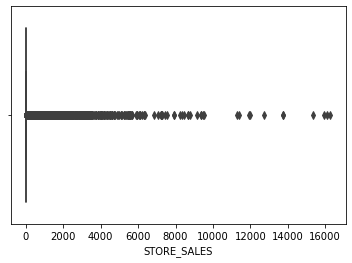

In [25]:
sns.boxplot(data=df, x='STORE_SALES')

<AxesSubplot:xlabel='SALES'>

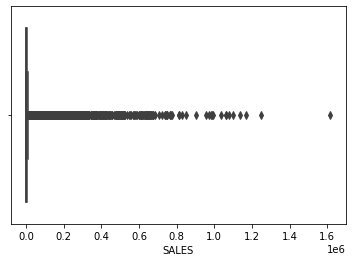

In [26]:
sns.boxplot(data=df, x='SALES')

Мы видим, что выборка сильно смещена вправо. Для обучения моделей уберем 2.5% самых больших значений, поскольку они с наибольшей вероятностью являются выбросами

Рассчитаем, сколько записей мы удалим

In [27]:
print(df.loc[df['STORE_SALES'] < 0, 'STORE_SALES'].count())
print(df.loc[df['SALES'] < 0, 'SALES'].count())

0
0


In [28]:
q_sales, q_store = df.quantile(.975)
len(df.query("SALES > @q_sales or STORE_SALES > @q_store"))

5058

Всего около 5 тысяч записей, что вполне приемлемо

In [29]:
df = df.query("SALES <= @q_sales and STORE_SALES <= @q_store").reset_index(drop=True)

Посмотрим на средние уровни продаж в категориях в разрезе месяцев

In [30]:
gb = df.groupby(['MONTH', 'ARTICLE_GROUP'])['SALES'].mean().to_frame().reset_index()

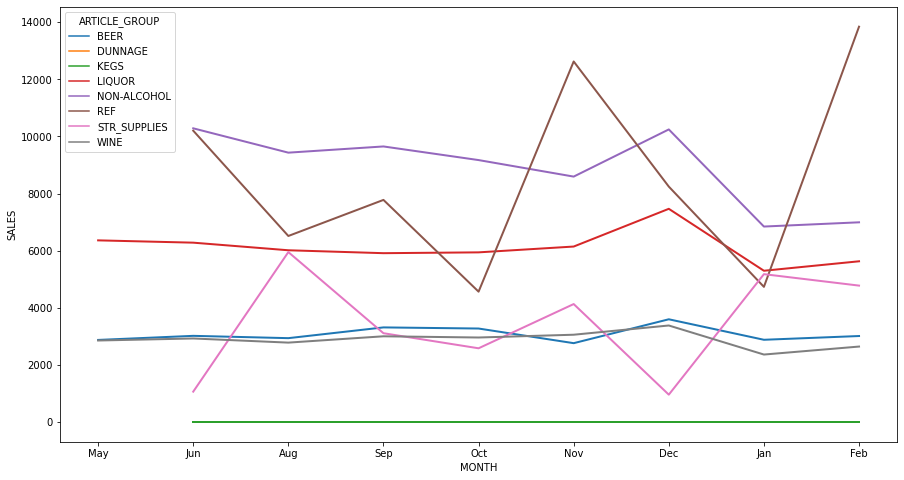

In [31]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(ax=ax, data=gb, x='MONTH', y='SALES',
             hue='ARTICLE_GROUP', linewidth = 2);

По графику видно, что продажи существенно отличаются в разных категориях

Как мы видим, две категории вообще имеют нулевые продажи

In [32]:
gb_store = df.groupby(['MONTH', 'ARTICLE_GROUP'])['STORE_SALES'].mean().to_frame().reset_index()

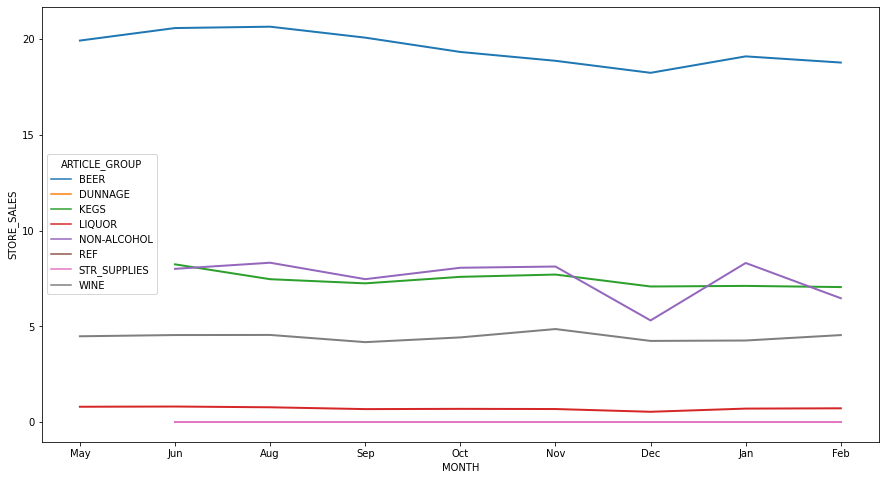

In [33]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(ax=ax, data=gb_store, x='MONTH', y='STORE_SALES',
             hue='ARTICLE_GROUP', linewidth=2);

Сравним топы категорий в целом и в магазине

In [34]:
gb_store.groupby('ARTICLE_GROUP')['STORE_SALES'].mean().sort_values(ascending=False)

ARTICLE_GROUP
BEER            19.499087
NON-ALCOHOL      7.503542
KEGS             7.431172
WINE             4.449580
LIQUOR           0.708212
REF              0.000000
STR_SUPPLIES     0.000000
DUNNAGE               NaN
Name: STORE_SALES, dtype: float64

In [35]:
gb.groupby('ARTICLE_GROUP')['SALES'].mean().sort_values(ascending=False)

ARTICLE_GROUP
NON-ALCOHOL     8900.078223
REF             8561.166667
LIQUOR          6114.872452
STR_SUPPLIES    3468.040210
BEER            3073.548727
WINE            2884.521971
KEGS               0.000000
DUNNAGE                 NaN
Name: SALES, dtype: float64

In [36]:
df['ARTICLE_NAME'].describe()

count                              117740
unique                              23232
top       LA VIELLE FERME CDV RED - 750ML
freq                                   18
Name: ARTICLE_NAME, dtype: object

In [37]:
df['CONTRAGENT'].describe()

count                                117740
unique                                  332
top       REPUBLIC NATIONAL DISTRIBUTING CO
freq                                   9491
Name: CONTRAGENT, dtype: object

Тест на корреляцию (сравниваем одни величины, логично предположить линейную зависимость)

In [38]:
np.round(df['SALES'].corr(df['STORE_SALES']), 4)

0.3448

## Выводы по EDA

1. Данные  содержат незначительное число пропусков, которые можно безопасно убрать. Уровни продаж имеют вероятные ошибки в данных (отрицательные продажи) и высокую дисперсию. Частично компенсируем это, убрав отрицательные продажи и 2.5% самых больших значений в данных

2. Продажи в апреле равны нулю, поскольку один из уровней продаж (общий) является целевой переменной, целесообразно убрать их совсем. Кроме того, полностью отсутствуют данные за июль.

3. Временной период представленной выборки составляет менее года. Это не позволяет выявить (потенциальную) сезонную зависимость, поэтому признак года убрали совсем, а месяцы переиндексировали в соответствии с хронологическим порядком следования (апрель - февраль), исключая июль. Также исключили признак кода товара, поскольку он обозначает то же, что и название товара, но менее удобен для восприятия. Название товаров преобразуем в числа перед передачей в модель.

4. Уровень продаж зависит от категории, также в части категорий продажи равны нулю.

5. Между целевой переменной и уровнем продаж в магазине существует средней силы линейная корреляция.

# ML

## Предобработка

Повторим загрузку данных, в этот раз перед удалением выбросов выделим тренировочную часть и будем удалять их только из нее. Таким образом тестовая выборка будет лучше моделировать поведение модели на новых данных.

Исключением будут являться пропуски и отрицательные продажи, т.к. это скорее ошибка в данных, чем аномальное значение

In [39]:
df = pd.read_csv(r'.\junior\regression\data_regression_for_task.csv')
df = df.dropna(subset=['CONTRAGENT', 'ARTICLE_GROUP'])
df = df.drop(['ARTICLE_CODE', 'YEAR'],
             axis=1)  # пропусков мало, будем считать тех. ошибкой и сбрасывать в т.ч. на тест части
df.loc[:, 'ARTICLE_GROUP'] = df.loc[:, 'ARTICLE_GROUP'].astype('category')
df.loc[:, 'MONTH'] = df.loc[:, 'MONTH'].replace(dict((enumerate(calendar.month_abbr))))
df.loc[:, 'MONTH'] = df.loc[:, 'MONTH'].astype(ct)
df = df[(df['SALES'] >= 0) & (df['STORE_SALES'] >= 0)]  # отриц. продажи сбрасываем в т.ч. на тесте
df = df[df['MONTH'] != 'Apr']
df['MONTH'].cat.remove_categories(['Apr', 'Jul'], inplace=True)

ТЕСТ (убираем категории с нулячими продажами)

In [40]:
df.groupby('ARTICLE_GROUP')['SALES'].sum().sort_values().head(3)

ARTICLE_GROUP
DUNNAGE         0.0
KEGS            0.0
REF        281340.0
Name: SALES, dtype: float64

In [41]:
df = df[~df['ARTICLE_GROUP'].isin(['DUNNAGE', 'KEGS'])]

Заменяем названия на порядковый номер месяца *в нашей выборке*

In [42]:
df.groupby('ARTICLE_GROUP')['SALES'].sum().sort_values().head(3)

ARTICLE_GROUP
DUNNAGE         0.0
KEGS            0.0
REF        281340.0
Name: SALES, dtype: float64

In [43]:
df['MONTH'] = df['MONTH'].cat.codes + 1

Функции предобработки для текстовых фич

In [44]:
def preprocess_text_feature(text: str) -> str:
    """Убирает не цифро-буквенные символы
    
    Args:
      text: входная строка
      
    Returns:
      text: обработанная строка
    """
    
    text = text.replace('\r', ' ')
    text = text.replace('\t', ' ')
    text = text.replace('\n', ' ')
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = text.lower().strip()
    return text


def preprocess_name(text: str) -> str:
    """Убирает стоп-слова из строки
    
    Испольуется английский словарь библиотеки nltk
    
    Args:
      text: входная строка
      
    Returns:
      text: обработанная строка    
    """
    
    stopwords = nltk.corpus.stopwords.words('english')
    return ' '.join(w for w in text.split() if w not in stopwords)

In [45]:
# takes a while to compute
df.loc[:, 'CONTRAGENT'] = df.loc[:, 'CONTRAGENT'].apply(preprocess_text_feature)
df.loc[:, 'ARTICLE_NAME'] = df.loc[:, 'ARTICLE_NAME'].apply(preprocess_text_feature)
df.loc[:, 'ARTICLE_NAME'] = df.loc[:, 'ARTICLE_NAME'].apply(preprocess_name)

Дропаем дубликаты, возникшие из-за товаров с одинаковым названием, но разным кодом

In [46]:
df = df.drop_duplicates()

### Feature engineering (*отбраковано*)

Создадим новые признаки, которые будут содержать продажи за предыдущий месяц

In [47]:
# df = df.sort_values(by='MONTH')

# for lag in 1,:
#     df['sales_lag_{}'.format(lag)] = df.groupby('ARTICLE_NAME')['STORE_SALES'].shift(lag)

Пропуски будут у первых месяцев - при появлении товара. Их можно либо заполнить нулем (создадим перекос в данных), либо дропнуть. Дроп будет существенным, пробуем заполнить нулем

In [48]:
# df.loc[:, ['sales_lag_1']] = df.loc[:, 'sales_lag_1'].fillna(0)

In [49]:
# df.isnull().sum()

Результат себя не оправдал, убираем. Доп. фича не улучшает деревянные модели, но ломает линейные

### Разделение на train, validation и test

In [50]:
train_val, test = df[df['MONTH'] != 8], df[df['MONTH'] == 8]  # 8 - код февраля
train_val = train_val.query(
    "SALES <= @q_sales and STORE_SALES <= @q_store"
)  # квантили берем из расчета в целом по выборке
X_train_val, y_train_val = df.drop('SALES', axis=1), df['SALES']
X_test, y_test = test.drop('SALES', axis=1), test['SALES']
X_train_val = X_train_val.reset_index(drop=True)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  shuffle=False,
                                                  test_size=0.1)
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [51]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(107275, 5) (107275,)
(11920, 5) (11920,)
(12876, 5) (12876,)


### Подготовка признаков для передачи в модель

Кодирование категориальных признаков

In [52]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe_train = ohe.fit_transform(X_train[['ARTICLE_GROUP', 'CONTRAGENT']])
ohe_val = ohe.transform(X_val[['ARTICLE_GROUP', 'CONTRAGENT']])
ohe_test = ohe.transform(X_test[['ARTICLE_GROUP', 'CONTRAGENT']])

X_train = X_train.drop(['ARTICLE_GROUP', 'CONTRAGENT'], axis=1)
X_val = X_val.drop(['ARTICLE_GROUP', 'CONTRAGENT'], axis=1)
X_test = X_test.drop(['ARTICLE_GROUP', 'CONTRAGENT'], axis=1)

Векторизация текстовых признаков

In [53]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=3, max_features=10000)
train_name_tfidf = vectorizer.fit_transform(X_train['ARTICLE_NAME'].values)
val_name_tfidf = vectorizer.transform(X_val['ARTICLE_NAME'].values)
test_name_tfidf = vectorizer.transform(X_test['ARTICLE_NAME'].values)
X_train = X_train.drop('ARTICLE_NAME', axis=1)
X_val = X_val.drop('ARTICLE_NAME', axis=1)
X_test = X_test.drop('ARTICLE_NAME', axis=1)

Масштабирование численных признаков

In [54]:
scaler = MinMaxScaler()
X_train['STORE_SALES'] = scaler.fit_transform(X_train[['STORE_SALES']])
X_val['STORE_SALES'] = scaler.transform(X_val[['STORE_SALES']])
X_test['STORE_SALES'] = scaler.transform(X_test[['STORE_SALES']])

Конкатенация sparse-матриц в одну

In [55]:
train_sparse = scipy.sparse.hstack((ohe_train, train_name_tfidf, X_train.values)).tocsr()
val_sparse = scipy.sparse.hstack((ohe_val, val_name_tfidf, X_val.values)).tocsr()
test_sparse = scipy.sparse.hstack((ohe_test, test_name_tfidf, X_test.values)).tocsr()

## Training

Определение заданной метрики

In [56]:
def metric(y_true, y_pred):
    
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_pred) * 100

### Sanity check (dummy regressor)

In [57]:
dummy = DummyRegressor(strategy='median')
dummy.fit(train_sparse, y_train)
y_pred = dummy.predict(val_sparse)
metric(y_pred, y_val)

98.89109520908968

Результат: немного варьируется, обычно около 99 на валидации. Другие модели должны давать результат не хуже этого уровня

### Ridge regression

In [58]:
alpha = np.linspace(0.1, 5, 20)
array = [] 
for al in tqdm(alpha):
    model = Ridge(solver='sparse_cg', random_state=42, alpha=al, max_iter=2000)
    model.fit(train_sparse, y_train)
    y_pred = model.predict(val_sparse)
    array.append(metric(y_pred, y_val))
    
best_alpha = np.argmin(array)

  0%|          | 0/20 [00:00<?, ?it/s]

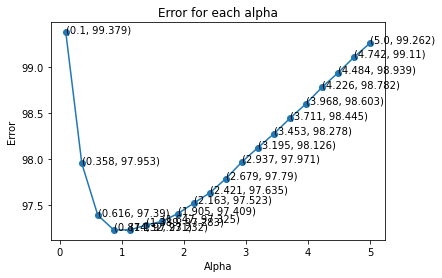

In [59]:
fig, ax = plt.subplots()
ax.plot(alpha, array)
ax.scatter(alpha, array)
for i, txt in enumerate(np.round(array,3)):
    ax.annotate((np.round(alpha[i], 3), np.round(txt, 3)), (alpha[i], array[i]))

plt.title("Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()

In [60]:
best_ridge_score = np.round(array[best_alpha], 4)
best_ridge_score

97.2314

Результат: 

- __72__ (без добавленной фичи)
- __84__ (без фичи и с убранными категориями с нулевыми продажами. непонятно, чего он расстроился)
- __97__ (сократили размерность TF-IDF)

С добавлением фичи сразу ломается (вероятно, из-за сильной корреляции - работает хуже дамми-регрессора)

### Random Forest

Для кросс-валидации используем сплиттер для временных рядов

In [61]:
time_cv = TimeSeriesSplit()

In [62]:
params= {'bootstrap': [False],
         'max_features': ['sqrt', None],
         'max_depth': [3, 6, 10],
         'n_estimators': [10, 20, 30],
         'min_samples_leaf': [8, 4],
         'min_samples_split': [5, 7],
        }

In [63]:
model = RandomForestRegressor(random_state=42)
cv = GridSearchCV(model,
                  params,
                  cv=time_cv,
                  scoring=make_scorer(metric, greater_is_better=False),
                  n_jobs=6)

In [64]:
train_val_sparse = scipy.sparse.vstack((train_sparse, val_sparse)).tocsr()

In [65]:
%time cv.fit(train_val_sparse, y_train_val)

Wall time: 3min 17s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=6,
             param_grid={'bootstrap': [False], 'max_depth': [3, 6, 10],
                         'max_features': ['sqrt', None],
                         'min_samples_leaf': [8, 4],
                         'min_samples_split': [5, 7],
                         'n_estimators': [10, 20, 30]},
             scoring=make_scorer(metric, greater_is_better=False))

In [66]:
cv.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': None,
 'min_samples_leaf': 8,
 'min_samples_split': 5,
 'n_estimators': 30}

In [67]:
cv.best_score_

-81.66342847383287

Результат: __133__ - при размерности TF-IDF 20000, __81__ - при размерности TF-IDF 10000

### LightGBM Regressor

In [68]:
time_cv = TimeSeriesSplit()
train_val_sparse = scipy.sparse.vstack((train_sparse, val_sparse)).tocsr()
model = lgb.LGBMRegressor()

In [ ]:
params= {'learning_rate': [0.17, 0.19, 0.21],
         'num_leaves': [15, 20],
         'reg_lambda': [0.1, 0.4],
         'max_depth': np.arange(3, 6),
         'n_estimators': [500, 1000]}

cv = GridSearchCV(model, params, cv=time_cv,
                  scoring=make_scorer(metric, greater_is_better=False),
                  n_jobs=6)

In [ ]:
%time cv.fit(train_val_sparse, y_train_val)

In [ ]:
cv.best_score_

In [ ]:
cv.best_params_

Чтобы не запускать GS повторно, отдельная ячейка с обучением модели с лучшими гиперпараметрами

In [70]:
best_params_lgb = {
    'learning_rate': 0.19,
    'max_depth': 5,
    'n_estimators': 1000,
    'num_leaves': 15,
    'reg_lambda': 0.1
}

In [71]:
# best_lgb = cv.best_estimator_  # раскомментить, если запускаем кросс-валидацию
best_lgb = lgb.LGBMRegressor(**best_params_lgb).fit(train_val_sparse, y_train_val)

Результат: ~ __0.62__

### CatBoost Regressor

In [ ]:
cat_model = CatBoostRegressor(logging_level='Silent',
                              random_state=42,
                              eval_metric='MAPE')
# todo: не допер, как же заставить его принимать кастомный скорер...

In [ ]:
%%time
cats_gs = cat_model.grid_search(
    {
        'learning_rate': [0.03, 0.05, 0.1], 
        'l2_leaf_reg': [0.5, 1],
        'depth': [5, 7],
        'n_estimators': [100, 200, 500]
    },
    train_val_sparse,
    y_train_val,
    cv=time_cv,
    plot=True,
    train_size=0.9
)

In [ ]:
best_cat_params = {
    'depth': 5,
    'l2_leaf_reg': 0.5,
    'iterations': 100,
    'learning_rate': 0.03
}

In [ ]:
pr = cat_model.predict(val_sparse)

In [ ]:
# metric(y_val, pr)

Результат: __85__ (последний прогон). До этого иногда выдавало что-то около 70. У LGBM скор в любом случае был выше

## Test time

Проверка лучшей модели (LightGBM) на тестовой выборке

In [73]:
t_y_pred = best_lgb.predict(test_sparse)
np.round(metric(y_test, t_y_pred), 4)

53.4025

**Итоговый результат (тест-сплит): 53.4**

Результат лучше, чем на валидации, вероятно, зависит от сплита, на графиках кота было видно, что более ранние сплиты имеют худший скор

Метрика расчитана по всей тест-выборке, попробуем отдельно посчитать страты (разбивка по категориям)

In [74]:
cats = df['ARTICLE_GROUP'].unique().tolist()

In [75]:
d = dict.fromkeys(cats)
for cat in cats:
    d[cat] = df.query("MONTH == 8").reset_index(drop=True).query("ARTICLE_GROUP == @cat").index.tolist()

In [76]:
results_by_cat = dict.fromkeys(d)

for cat_name, cat_indices in d.items():
    x_q = test_sparse[cat_indices, :]
    y_q = y_test.iloc[cat_indices]
    m_t_y_pred = best_lgb.predict(x_q)
    m_metric = metric(y_q, m_t_y_pred)
    results_by_cat[cat_name] = np.round(m_metric, 4)

In [77]:
dict(sorted(results_by_cat.items(), key=lambda item: item[1]))

{'NON-ALCOHOL': 36.6262,
 'BEER': 43.3137,
 'LIQUOR': 45.5495,
 'REF': 58.0945,
 'STR_SUPPLIES': 60.1499,
 'WINE': 68.6768}

In [78]:
df.groupby(['ARTICLE_GROUP'])['SALES'].mean().sort_values(ascending=False)

ARTICLE_GROUP
NON-ALCOHOL     14079.809028
BEER            13293.774326
LIQUOR          11626.636381
STR_SUPPLIES    10374.791667
REF              8274.705882
WINE             4116.945543
DUNNAGE                  NaN
KEGS                     NaN
Name: SALES, dtype: float64

- Category: NON-ALCOHOL: 37.0848
- Category: BEER: 41.9662
- Category: LIQUOR: 45.0763
- Category: REF: 63.6087
- Category: STR_SUPPLIES: 65.7112
- Category: WINE': 67.5968

Похоже на то, что качество предсказаний зависит от среднего уровня продаж

## Вывод

Текущая модель далека от идеала, но среди испытанных алгоритмов однозначно лучше всех показал себя градиентный бустинг LightGBM. Для улучшения результата можно попробовать генерацию дополнительных признаков, отбор уже существующих, более тщательную очистку входных данных и более тонкую настройку гиперпараметров